# SOM

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('../scripts')
from som.selfsom import SimpleSOMMapper
import som.somtools
from som.TransitSOM_release import CreateSOM, LoadSOM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [18]:
som_array = np.load('../som_input_arrays_20x20.npz')['array']
ids = np.load('../som_input_arrays_20x20.npz')['ids']
kshape = (20,20)

In [19]:
Kohonen = LoadSOM('../kohonen-3515-candidates-20x20.txt',kshape[0],kshape[1],121)
K = Kohonen.K

In [20]:
## map the data onto a pixel
mapped = Kohonen(som_array)
mapped_tuples = [tuple(point) for point in mapped]
## count how many are in that pixel
counts = Counter(mapped_tuples)
count_list = [counts[item] for item in mapped_tuples]

In [21]:
x_pos = mapped[:,0]
y_pos = mapped[:,1]

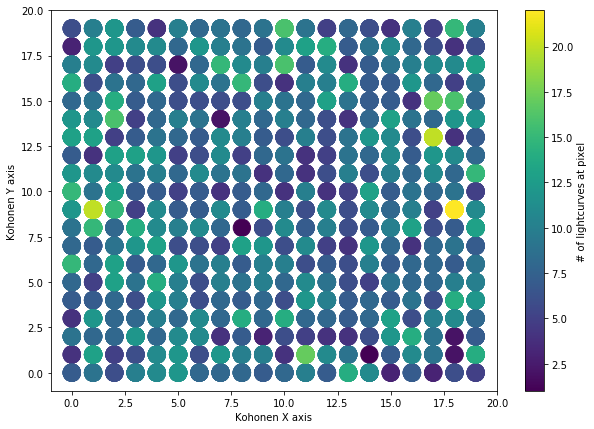

In [22]:
plt.figure(figsize=(10,7))
plt.xlim([-1,kshape[1]])
plt.ylim([-1,kshape[0]])
plt.xlabel('Kohonen X axis')
plt.ylabel('Kohonen Y axis')
plt.scatter(y_pos,x_pos,c=count_list,s=300)
plt.colorbar(label='# of lightcurves at pixel')
plt.savefig('kohonen_layers.png')
plt.show()

### Functions

In [23]:
from matplotlib.backends.backend_pdf import PdfPages

In [24]:
def plot_all_arrays(som, bins=np.arange(121), save=True,save_path='kohonen_pixels.png',kshape=kshape):
    """
    
    save_path = please remember to add the suffix (eg: .png)
    """
    fig, axes = plt.subplots(kshape[0],kshape[1], figsize=(50, 50),sharey=True)
    #fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height spacing between subplots

    for x_pixel in range(kshape[0]):
        for y_pixel in range(kshape[1]):
            ax = axes[x_pixel, y_pixel]
            ax.scatter(bins, som[x_pixel, y_pixel], c='g',s=3)
            ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel, y_pixel))
            #ax.set_ylim(0, max(som[x_pixel, y_pixel]))
            #ax.text(0, 0.92, '[{},{}]'.format(x_pixel, y_pixel))
    
    if save:
        plt.savefig('{}'.format(save_path),dpi=200)  # Save the figure if save is True
    
    plt.show()
    
def _get_lightcurves(ids,mapped_tuples,pixel):
    """
    This function retrieves lightcurves in the SOM pixels. 
    
    :ids: TIC IDs from `stack_npz_files`
    :mapped_tuples: Obtained from the SOM process, where this is the coordinates of the lightcurve
    :pixel: desired pixel to retrieve lightcurves
    :dir: Directory of where original `.npz` files are.
    
    outputs:
        lightcurve plots.
    pixel has to be in the form of (x,y) coordinates"""
    df = pd.DataFrame(data=[ids,mapped_tuples]).T
    
    pdf_pages = PdfPages("pixel_{}.pdf".format(pixel))
    ## change tuples to columns for faster calculations
    df.columns = ['TIC','coords']
    lightcurves = df.groupby('coords').get_group(pixel).reset_index(drop=True)
    ids_in_pixel = []
    for i in lightcurves.TIC:
        #file_pattern = os.path.join(directory, '**', f'*{number_}*')
        lc = np.load("../som_cutouts_3515-candidates/{}.npz".format(i))
        ids_in_pixel.append(i)
        median = np.median(lc['flux'])
        abs_depth = median - np.min(lc['flux'])  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = (lc['flux'] - median) / abs_depth + 1
        
        
        ## background subtraction
        x1 = np.median(lc['flux'][0:12])
        x2 = np.median(lc['flux'][-13:-1]) # the last 12 points

        y1 = np.median(lc['time'][0:24])
        y2 = np.mean(lc['time'][-25:-1])
        grad = (x2-x1)/(y2-y1)
        background_level = x1 + grad * (lc['time'] - y1)
        original_flux = lc['flux'].copy()
        
        flux = original_flux - background_level
        
        #normalised_lightcurve = (flux)/np.median(flux)
        median = np.median(flux)
        #depth_normalised_lightcurve = (data['flux'] - median) / median
        abs_depth = median - np.min(flux)  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
        #elif normalisation_method == 'depth and width':
    

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns of subplots
        plt.title("TIC {}".format(i))

        # First subplot (left side)
        axs[0].set_title("TIC {} - depth normalised".format(i))
        axs[0].scatter(lc['time'], depth_normalised_lightcurve, s=5)

        # Second subplot (right side)
        axs[1].set_title("TIC {} - subtracted background".format(i))
        axs[1].scatter(lc['time'], lc['flux']/np.median(lc['flux']), s=5)

        plt.tight_layout()  # To ensure proper spacing between subplots
        plt.show()
        
        pdf_pages.savefig(fig)
    pdf_pages.close()

        
    return df, ids_in_pixel

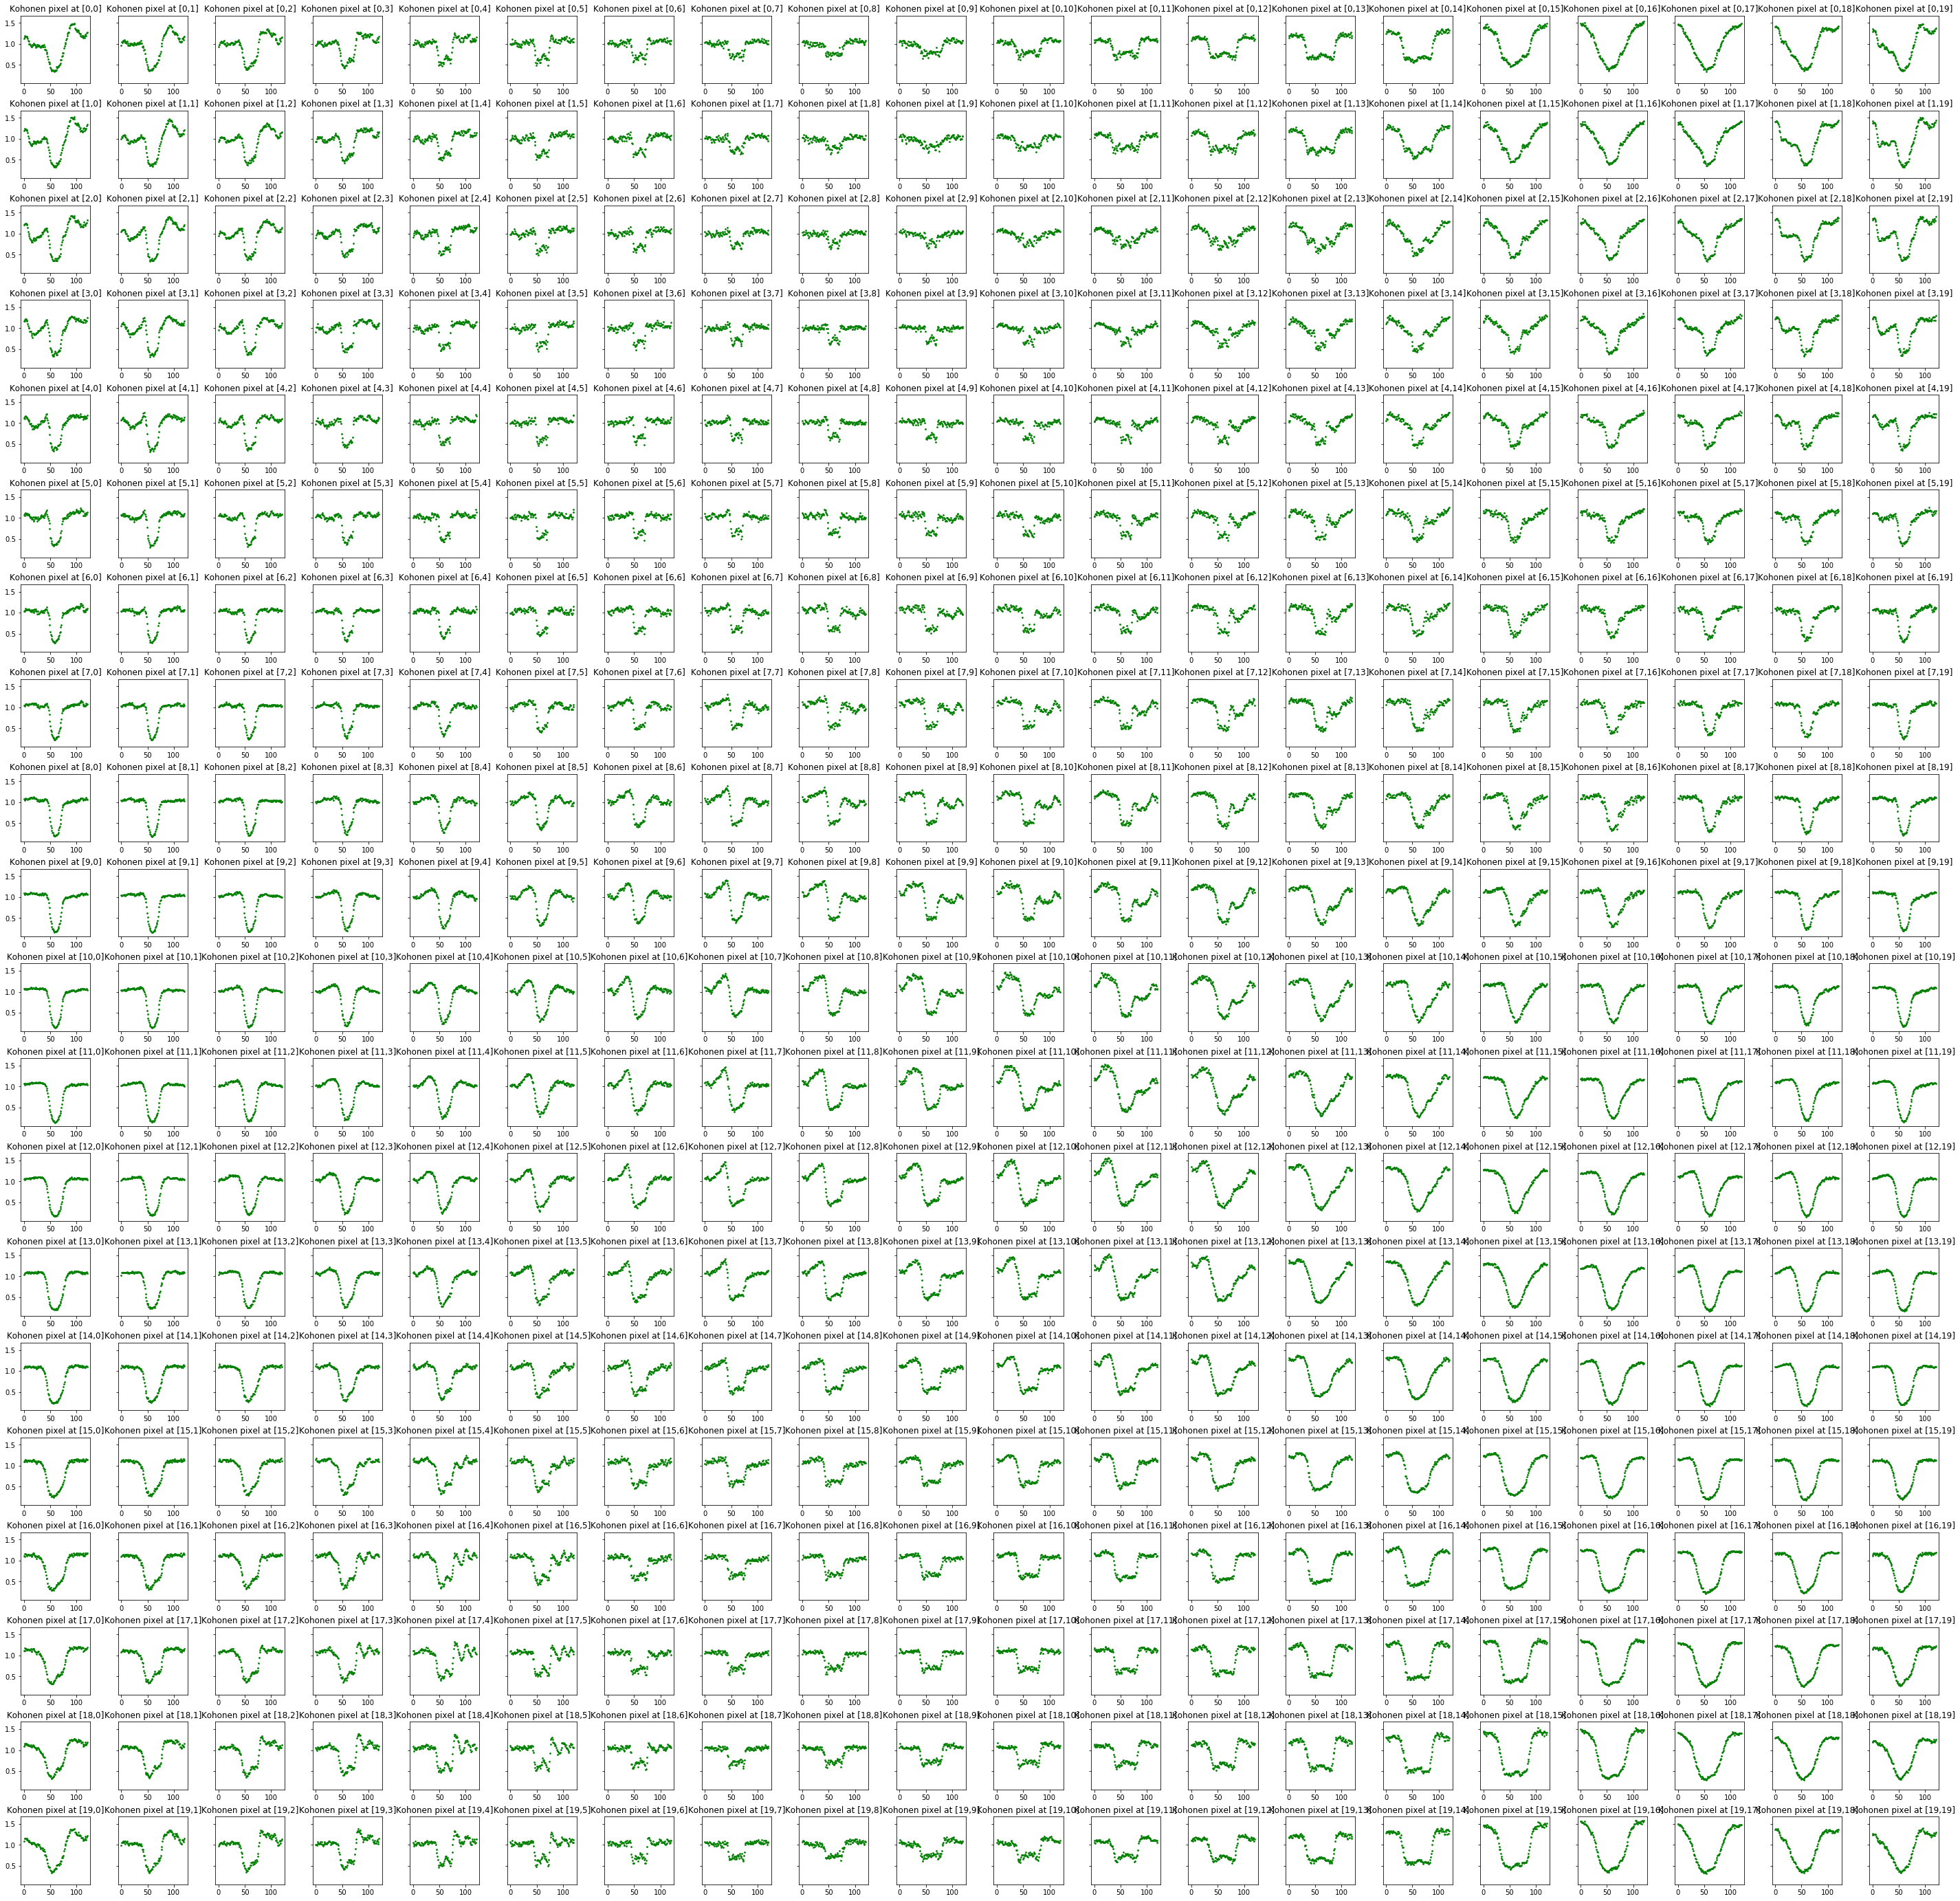

In [25]:
plot_all_arrays(K)

In [26]:
from astropy.io import fits

In [27]:
data = pd.read_csv('../candidates/candidates-full-df.csv')
# need to make one for the 3k candidates, as this one is for the 910 candidates.

In [ ]:
def plot_candidates():
    hdul = fits.open()
    table = hdul[1].data
    plt.scatter(table['TIME'],table['PCA_FLUX'],s=10)
    plt.show()

---

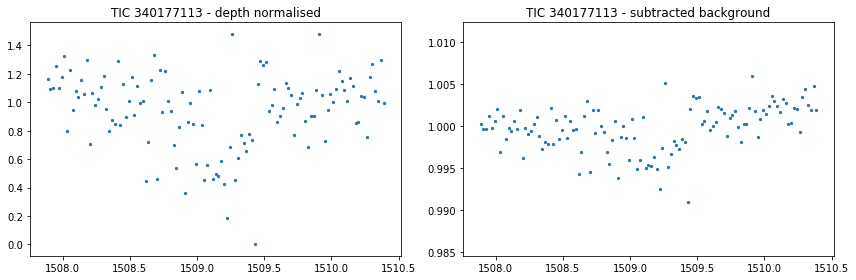

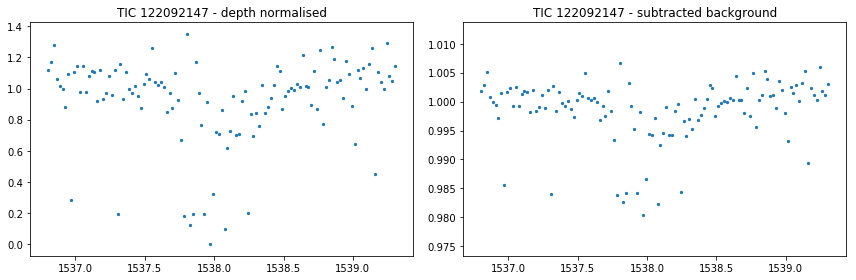

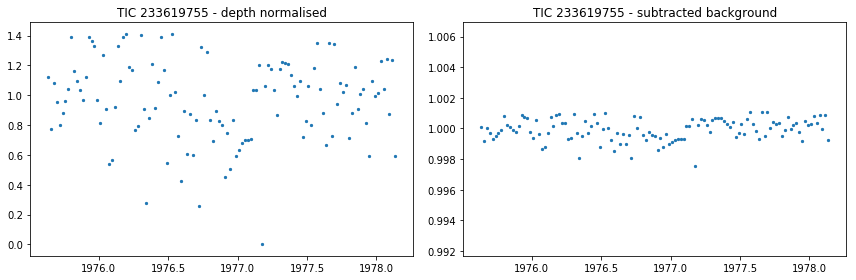

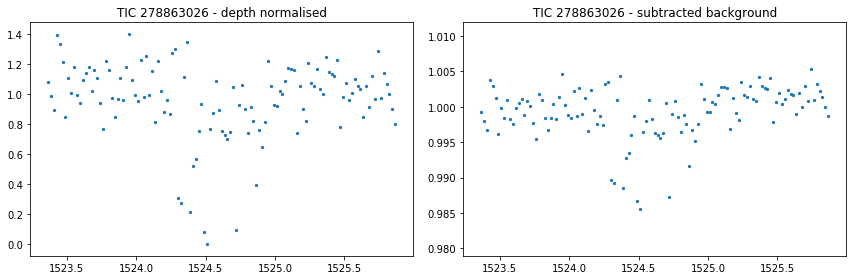

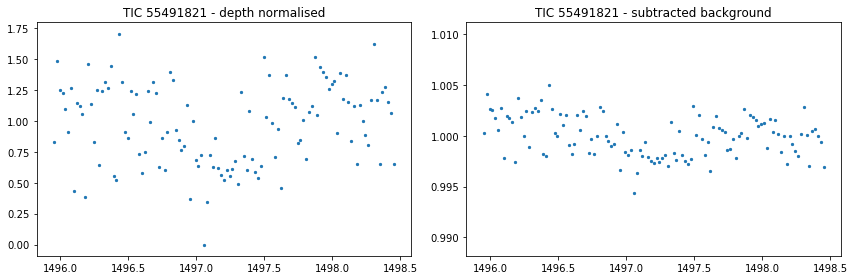

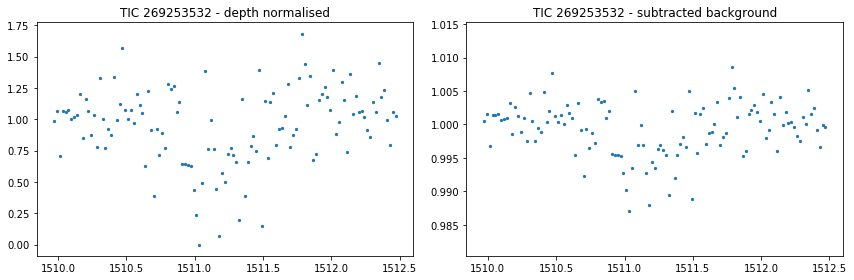

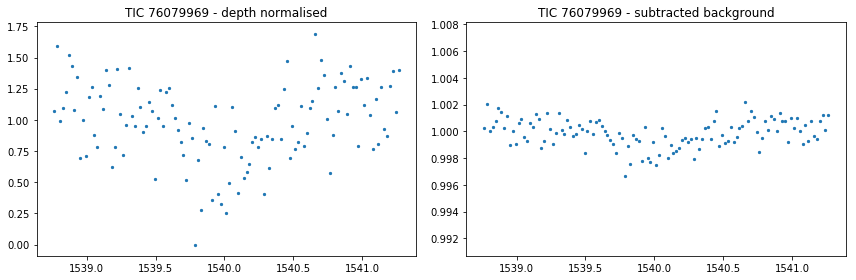

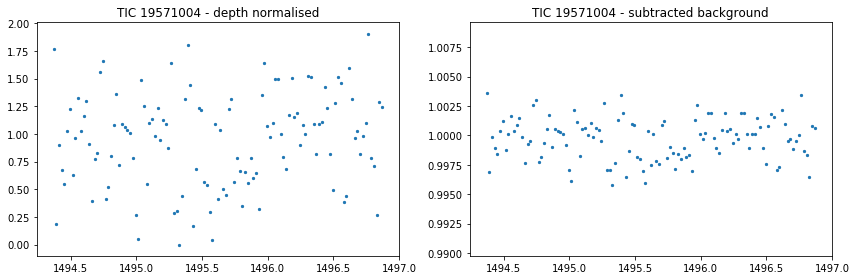

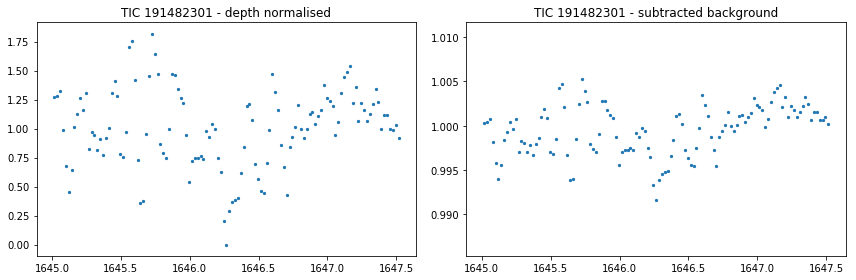

In [32]:
_, _ = _get_lightcurves(ids,mapped_tuples,(19,7))

In [9]:
import pandas 

In [10]:
data = pd.read_csv('../candidates/candidates-full-df.csv')


In [11]:
tic_ids_df = pd.DataFrame({'TIC_ID': ids, 'pos': mapped_tuples})

In [12]:
df = pd.merge(tic_ids_df,data,on='TIC_ID',how='inner')

In [45]:
df[df.pos == (4,5)]['class']

102      red
155      red
242      red
462      red
493      red
566      red
746    green
883      red
Name: class, dtype: object

In [24]:
get_lightcurves(df[df.pos == (9,9)].TIC_ID,mapped_tuples,(9,9))

AttributeError: 'builtin_function_or_method' object has no attribute 'get_indexer'

In [43]:
grouped_data = df.groupby(['pos','class'])['class'].count()

In [44]:
grouped_data

pos     class 
(0, 0)  purple     4
        red        1
        yellow     1
(0, 1)  purple     3
        yellow     1
(0, 2)  purple     9
        red        1
        yellow     3
(0, 3)  orange     1
        purple     7
        yellow     1
(0, 4)  orange     3
        purple     4
        yellow     1
(0, 5)  orange     1
        purple     8
        red        1
(0, 6)  purple     2
        red        4
(0, 7)  orange     1
        purple     9
        red        1
(0, 8)  orange     2
        purple    11
(0, 9)  purple     7
        red        1
(1, 0)  purple     9
        red        1
(1, 1)  orange     1
        purple     3
                  ..
(8, 7)  purple     7
        red        2
        yellow     1
(8, 8)  purple     3
        yellow     3
(8, 9)  orange     2
        purple     8
(9, 0)  purple    10
(9, 1)  purple     5
        red        1
(9, 2)  purple     8
(9, 3)  orange     1
        purple     5
        red        1
(9, 4)  purple     4
        red        